In [37]:
from Analysis.Analysis import * 
from Model.Model import *
from Model.config import DEFAULT_PASSER, TM_NGS, TM_NNP
import numpy as np
from tqdm import tqdm
import pickle

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use(['science','no-latex'])
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.dpi'] = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### In vitro data

In [3]:
def load_from_pkl(path):
    # load data from pickle file (recommanded)
    with open(path,'rb') as f:
        dnas = pickle.load(f)
    return dnas

def sample_to_depth(dnas, depth):
    dna_number = len(dnas)
    readout_number = sum([dna['num'] for dna in dnas])
    p = depth * dna_number / readout_number
    SAM = Sampler(p)
    return SAM(dnas)

For efficiency, the data is loaded from a preprocessed pickle file here. The data can also be loaded from raw csv file using load_from_csv('data.csv'), and the result will be the same.

In [60]:
len(in_dnas)

1891

In [6]:
dnas = load_from_pkl('files/Seq_data.pkl')
dcs = [dna_chunk(dna) for dna in dnas]
in_dnas = [dna['ori'] for dna in dnas]

Under several sequence depth, compute reference sequence lost number and sequences with more than N errors of the actural data(N is set to 1 here). 

In [ ]:
# obtain reference lost number and error number
L_ref = []
E_ref = []
D = [10,20,40,70,100]
for depth in D:
    error_numbers = []
    lost_numbers = []
    for i in range(5): # 10 repeative experiments
        dnas_ds = sample_to_depth(dnas, depth)
        lost_number, error_number = inspect_number_only(dnas_ds, num_th = 1)
        lost_numbers.append(lost_number)
        error_numbers.append(error_number)
        # TODO: tqdm, print without switching lines.
        print(f'{i+1} / 10 repeat experiment under depth {depth}, lost number: {lost_number}, error_number: {error_number}', end = '\r')
    E_ref.append(sum(error_numbers)/10)
    L_ref.append(sum(lost_numbers)/10)
    
print(L_ref, E_ref)

The computation can be kind of time-consuming. You can skip the previous block, and use the results directly:

In [8]:
# results:
L_ref, E_ref = ([151.0, 109.7, 79.1, 59.5, 50.9], [210.4, 105.7, 86.1, 87.2, 89.2])
D = [10,20,40,70,100]

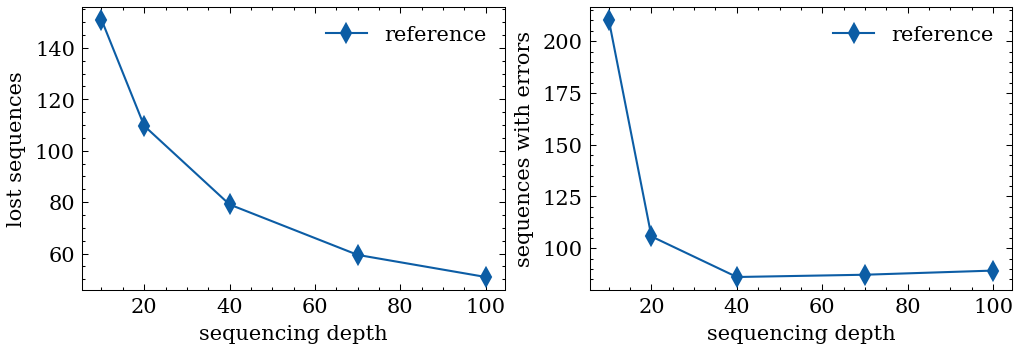

In [9]:
# draw the trend
plt.figure(figsize = (8,2.5))

plt.subplot(1,2,1)
plt.plot(D, L_ref,'-d',label = 'reference')
plt.xlabel('sequencing depth')
plt.ylabel('lost sequences')
plt.legend()

plt.subplot(1,2,2)
plt.plot(D, E_ref,'-d',label = 'reference')
plt.xlabel('sequencing depth')
plt.ylabel('sequences with errors')
plt.legend()

### In silco simulation

In [45]:
arg = DEFAULT_PASSER
arg.syn_number = 15
arg.syn_yield = 0.985
arg.syn_sub_prob = 0.0002
arg.syn_del_prob = 0.0001
arg.syn_ins_prob = 0.0001

arg.pcrp = 0.7
arg.pcrBias = 0.12

arg.sam_ratio = 0.0001
arg.seq_copies = 60000
arg.seq_performPCR = False




def simulate(in_dnas, arg, seq_depths = [10, 20, 40, 70, 100], return_dna = False):
    
    syn_out_numbers = arg.syn_number * arg.syn_yield ** len(in_dnas[0])
    amplify_ratio = 10000 / syn_out_numbers
    arg.pcrc = int(log(amplify_ratio) / log(arg.pcrp+1))
    
    arg.seq_depth = max(seq_depths)
    Modules =  [
                ('synthesizing',Synthesizer(arg)),
               ('pcring',PCRer(arg = arg, N = 12)),
                ('sampling',Sampler(arg = arg)),
                ('pcring', PCRer(arg = arg, N = 27)),
                ('sequencing', Sequencer(arg))
    ]

    Model = DNA_Channel_Model(Modules, arg)
    L, E = [], []
    out_dnas = Model(in_dnas, print_state = False)
    
    if return_dna: return out_dnas
    
    for seq_depth in seq_depths[:-1]:
        dnas_ds = sample_to_depth(out_dnas, seq_depth)
        lost_number, error_number = inspect_number_only(dnas_ds, num_th = 1)
        L.append(lost_number)
        E.append(error_number)
    lost_number, error_number = inspect_number_only(out_dnas, num_th = 1)
    L.append(lost_number)
    E.append(error_number)
    return L, E

In [57]:
L_simus, E_simus = [], []
for i in range(5):
    L, E = simulate(in_dnas, arg, seq_depths = D)
    L_simus.append(L)
    E_simus.append(E)
    print(f'{i+1} / 5 repeat experiment, L = {L}, E = {E}', end = '\r')

L_simus = np.array(L_simus)
E_simus = np.array(E_simus)
L_simu = list(np.average(L_simus, axis = 0))
E_simu = list(np.average(E_simus, axis = 0))

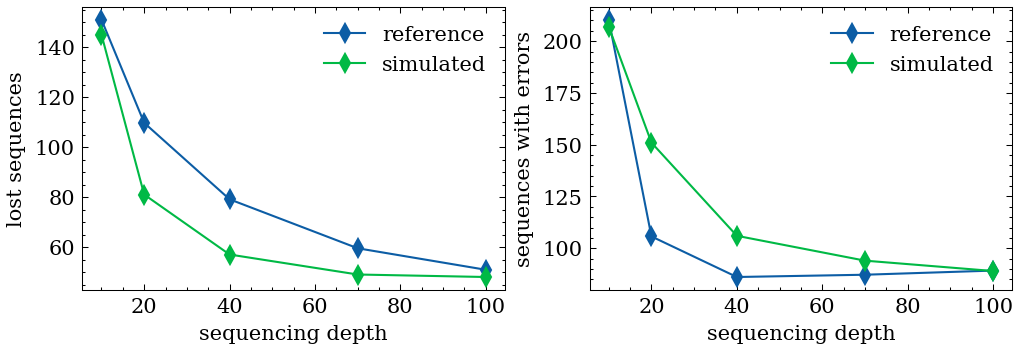

In [58]:
# plot 2: simulated and reference trends
plt.figure(figsize = (8,2.5))

plt.subplot(1,2,1)
plt.plot(D, L_ref,'-d',label = 'reference')
plt.plot(D, L_simu,'-d', label = 'simulated')
plt.xlabel('sequencing depth')
plt.ylabel('lost sequences')
plt.legend()

plt.subplot(1,2,2)
plt.plot(D, E_ref,'-d',label = 'reference')
plt.plot(D, E_simu,'-d', label = 'simulated')
plt.xlabel('sequencing depth')
plt.ylabel('sequences with errors')
plt.legend()

### (If you want to load data from csv)

In [15]:
def load_from_csv(path):
    # load data from csv. May take several minutes.
    data = []
    with open(path,'r') as f:
        while True:
            line  = f.readline()
            if line == '':
                break
            for d in line.split('/n'):
                data.append(d.split(','))
        f.close()

    dnas = []
    for d in tqdm(data):
        # extract original DNA sequence
        ori_dna = d[0][2:-2][15:-15] # "['ACCGG....ACGAGT']" -> "ACCGG....ACGAGT"

        # extract DNA readouts
        re_dnas = []
        for i in range(1,len(d),3):
            # compute difference between original sequence and readout sequence
            re_dnas.append([int(d[i+2]),diff(ori_dna, d[i+1][15:-15]),d[i+1][15:-15]])

        # get total reads
        readout_num = sum([re_dna[0] for re_dna in re_dnas])

        # construct DNA chunk
        dna = {
            'ori': ori_dna,
            're': re_dnas,
            'num': readout_num
        }
        dnas.append(dna)
    
    return dnas

def diff(res, ref):
    res = np.array(res)
    ref = np.array(ref)
    return np.sum(np.abs(res - ref) / ref)